## Data Understanding and Preparation

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Proj_2/telecom_churn_data.csv")

In [5]:
# Inspect dataset
print("Dataset Shape:", data.shape)
print("Missing Values:\n", data.isnull().sum().sum())
print("Data Types:\n", data.dtypes.value_counts())

Dataset Shape: (99999, 226)
Missing Values:
 3594931
Data Types:
 float64    179
int64       35
object      12
Name: count, dtype: int64


In [6]:
# Step 1: Analyze missing values
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_df = missing_percentage.reset_index()
missing_df.columns = ['Column', 'Missing_Percentage']
missing_df = missing_df.sort_values(by='Missing_Percentage', ascending=False)
print("Columns with missing values:\n", missing_df[missing_df['Missing_Percentage'] > 0])

Columns with missing values:
                    Column  Missing_Percentage
189             arpu_3g_6           74.846748
197      night_pck_user_6           74.846748
161     total_rech_data_6           74.846748
193             arpu_2g_6           74.846748
165       max_rech_data_6           74.846748
..                    ...                 ...
7    last_date_of_month_8            1.100011
4          loc_ic_t2o_mou            1.018010
3          std_og_t2o_mou            1.018010
2          loc_og_t2o_mou            1.018010
6    last_date_of_month_7            0.601006

[166 rows x 2 columns]


In [7]:
# Step 2: Handle missing values
# Drop columns with more than 70% missing values
threshold = 70
data = data.drop(columns=missing_df[missing_df['Missing_Percentage'] > threshold]['Column'])

# Convert date columns to datetime format
date_cols = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9']
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce')  # Convert to datetime, setting errors as NaT

# Fill missing values in date columns with the previous month's last date
data[date_cols] = data[date_cols].ffill()

# Impute missing values for numerical columns with median
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

In [8]:
# Step 3: Filter High-Value Customers
# Compute average recharge amount for months 6 & 7
avg_rech_amt = (data['total_rech_amt_6'] + data['total_rech_amt_7']) / 2

# Determine 70th percentile threshold
X = np.percentile(avg_rech_amt, 70)

# Retain only high-value customers
data_hvc = data[avg_rech_amt >= X].copy()

In [9]:
# Step 4: Tag Churners
# Define churn: Zero calls & zero internet usage in month 9
data_hvc['churn'] = ((data_hvc['total_ic_mou_9'] == 0) &
                    (data_hvc['total_og_mou_9'] == 0) &
                    (data_hvc['vol_2g_mb_9'] == 0) &
                    (data_hvc['vol_3g_mb_9'] == 0)).astype(int)

In [10]:
# Step 5: Drop churn-phase columns (month 9 attributes)
columns_to_drop = [col for col in data_hvc.columns if col.endswith('_9')]
data_hvc.drop(columns=columns_to_drop, inplace=True)

In [11]:
# Save cleaned dataset
data_hvc.to_csv("telecom_churn_cleaned.csv", index=False)

## Exploratory Data Analysis (EDA)

In [12]:
# Step 6: Check data imbalance
churn_counts = Counter(data_hvc['churn'])
print("Churn Distribution:", churn_counts)

Churn Distribution: Counter({0: 27418, 1: 2593})


In [13]:
# Apply SMOTE if imbalanced
if min(churn_counts.values()) / max(churn_counts.values()) < 0.2:
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    numeric_features = data_hvc.select_dtypes(include=[np.number]).drop(columns=['churn'])
    X_resampled, y_resampled = smote.fit_resample(numeric_features, data_hvc['churn'])
    resampled_data = pd.DataFrame(X_resampled, columns=numeric_features.columns)
    resampled_data['churn'] = y_resampled
    data_hvc = resampled_data.copy()
    print("Applied SMOTE to balance the dataset.")

Applied SMOTE to balance the dataset.


<ipython-input-13-ea12ec0d859f>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_data['churn'] = y_resampled


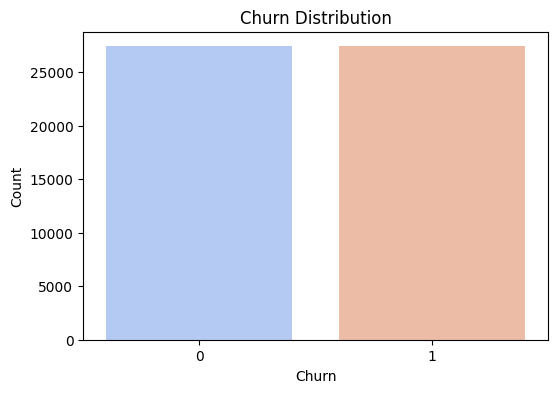

In [14]:
# Step 7: Visualization
# Distribution of churned vs non-churned customers
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', hue='churn', data=data_hvc, palette='coolwarm', legend=False)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

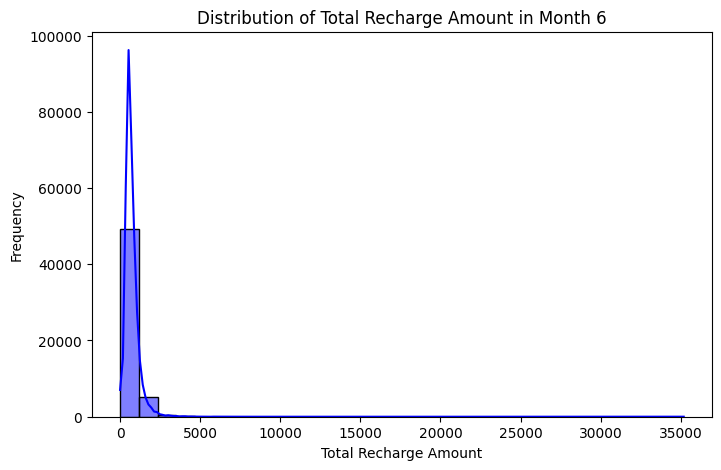

In [15]:
# Distribution of total recharge amount
plt.figure(figsize=(8, 5))
sns.histplot(data_hvc['total_rech_amt_6'], bins=30, kde=True, color='blue')
plt.title('Distribution of Total Recharge Amount in Month 6')
plt.xlabel('Total Recharge Amount')
plt.ylabel('Frequency')
plt.show()

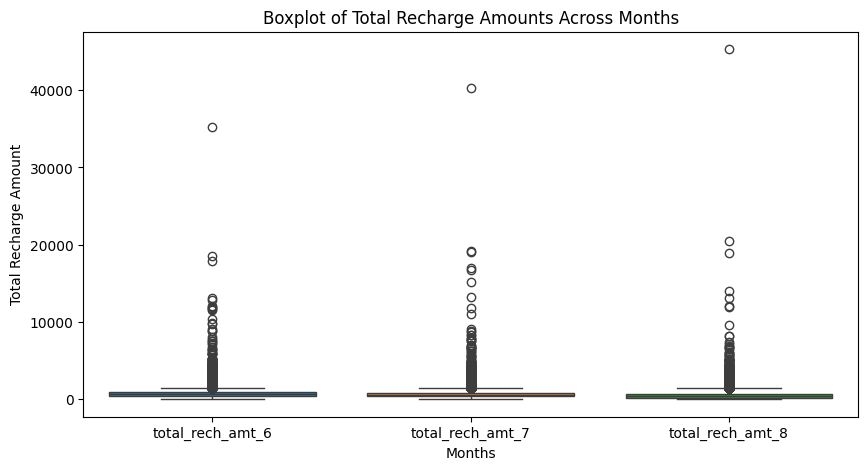

In [16]:
# Boxplot of recharge amount across months
plt.figure(figsize=(10, 5))
sns.boxplot(data=data_hvc[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8']])
plt.title('Boxplot of Total Recharge Amounts Across Months')
plt.ylabel('Total Recharge Amount')
plt.xlabel('Months')
plt.show()

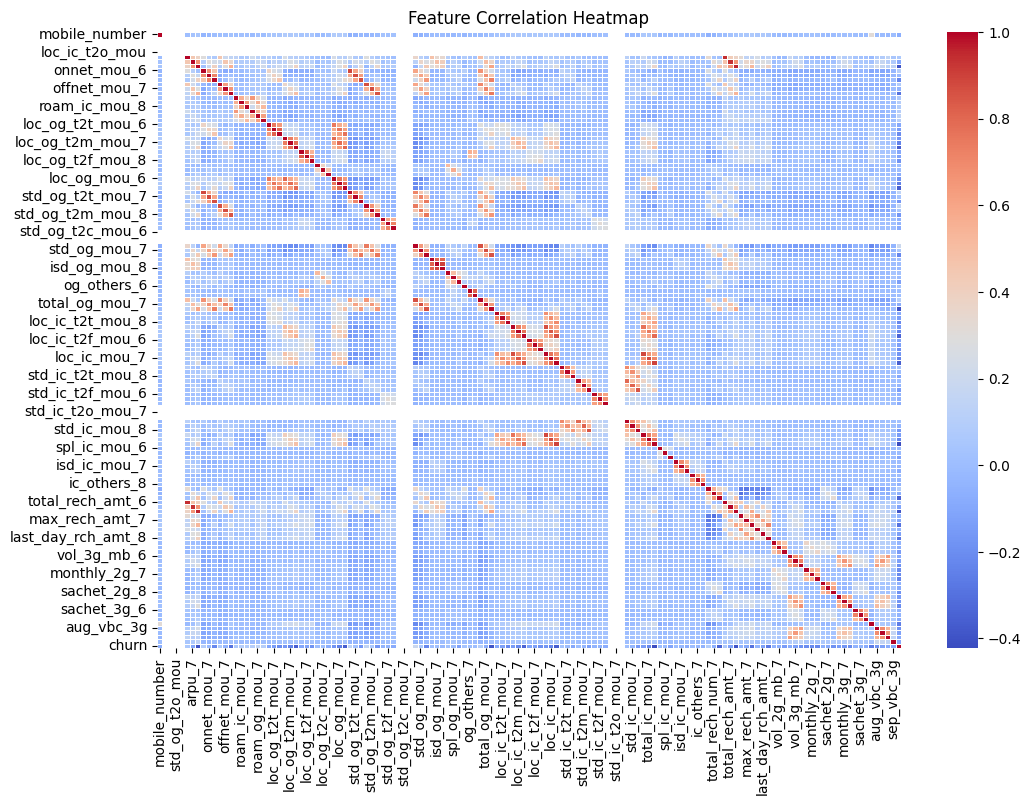

In [17]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = data_hvc.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

## Feature Engineering

In [18]:
# Step 8: Create new features
data_hvc['avg_rech_per_month'] = (data_hvc['total_rech_amt_6'] + data_hvc['total_rech_amt_7'] + data_hvc['total_rech_amt_8']) / 3
data_hvc['data_per_rech'] = (data_hvc['vol_2g_mb_6'] + data_hvc['vol_3g_mb_6']) / (data_hvc['total_rech_amt_6'] + 1)

In [19]:
# Feature selection: Remove low variance features
selector = VarianceThreshold(threshold=0.01)
selected_features = selector.fit_transform(data_hvc.select_dtypes(include=[np.number]))
selected_columns = data_hvc.select_dtypes(include=[np.number]).columns[selector.get_support()]
data_hvc = data_hvc[selected_columns]

## Model Building

In [20]:
# Step 9: # Split dataset
X = data_hvc.drop(columns=['churn'])
y = data_hvc['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Step 10: # Train models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Model Performance:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Model Performance:
[[4801  691]
 [ 631 4845]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5492
           1       0.88      0.88      0.88      5476

    accuracy                           0.88     10968
   macro avg       0.88      0.88      0.88     10968
weighted avg       0.88      0.88      0.88     10968

ROC-AUC Score: 0.9425144655590415

Decision Tree Model Performance:
[[4956  536]
 [ 415 5061]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5492
           1       0.90      0.92      0.91      5476

    accuracy                           0.91     10968
   macro avg       0.91      0.91      0.91     10968
weighted avg       0.91      0.91      0.91     10968

ROC-AUC Score: 0.913309125645005

Random Forest Model Performance:
[[5222  270]
 [ 226 5250]]
              precision    recall  f1-score   support

           0       0.96      0.95  

## Model Selection

In [23]:
#Step 11: Hyperparameter tuning for Random Forest using RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [24]:
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 100]},
                   random_state=42, scoring='roc_auc')

In [25]:
best_rf = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


In [26]:
y_pred = best_rf.predict(X_test)
print("\nOptimized Random Forest Model Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))


Optimized Random Forest Model Performance:
[[5195  297]
 [ 246 5230]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5492
           1       0.95      0.96      0.95      5476

    accuracy                           0.95     10968
   macro avg       0.95      0.95      0.95     10968
weighted avg       0.95      0.95      0.95     10968

ROC-AUC Score: 0.989169235203393


## Feature Importance Analysis

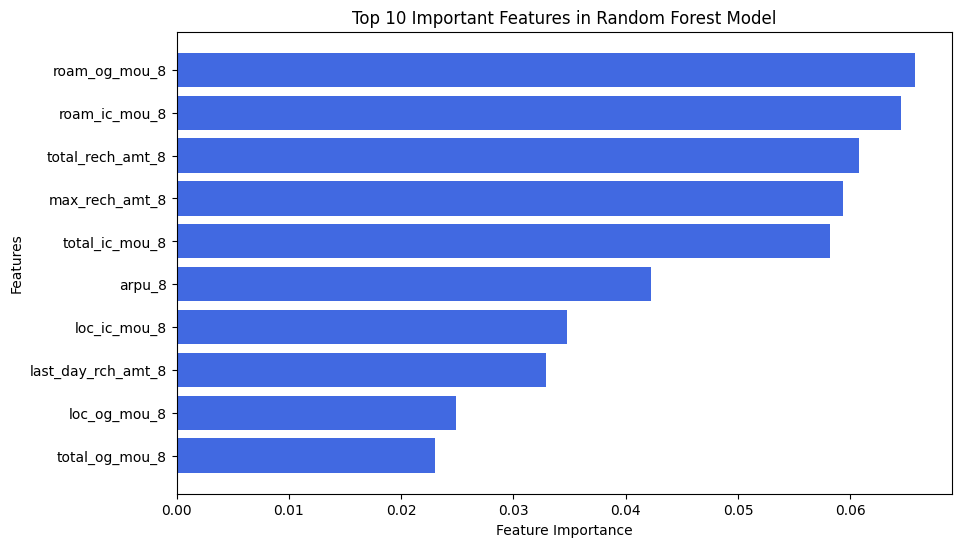

In [27]:
# Step 12: Feature Importance Analysis

feature_importance = pd.DataFrame({'Feature': data_hvc.drop(columns=['churn']).columns, 'Importance': best_rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10], color='royalblue')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Important Features in Random Forest Model")
plt.show()

## Model Evaluation and Interpretation

In [28]:
# Step 13: Model Evaluation and Interpretation
y_pred = best_rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))

Confusion Matrix:
 [[5195  297]
 [ 246 5230]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      5492
           1       0.95      0.96      0.95      5476

    accuracy                           0.95     10968
   macro avg       0.95      0.95      0.95     10968
weighted avg       0.95      0.95      0.95     10968

ROC-AUC Score: 0.989169235203393


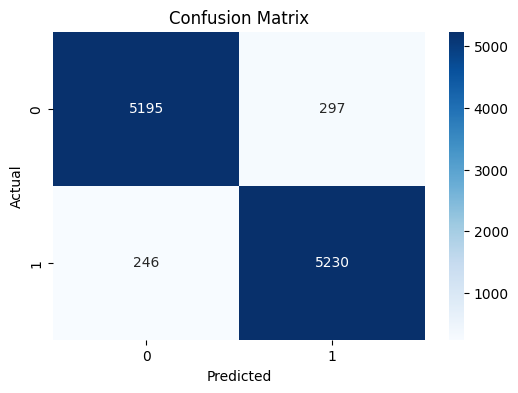

In [29]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

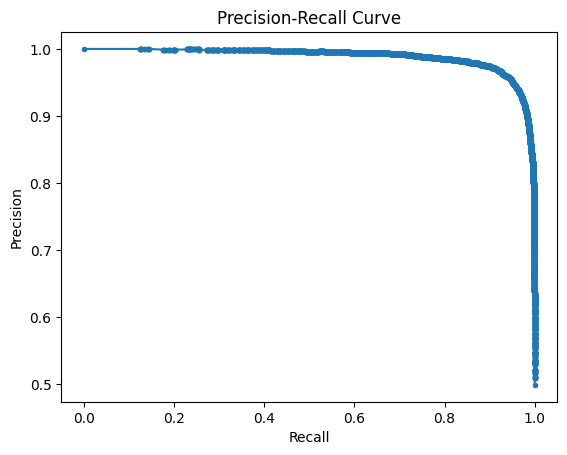

In [30]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Plotting AUC-ROC Curve...


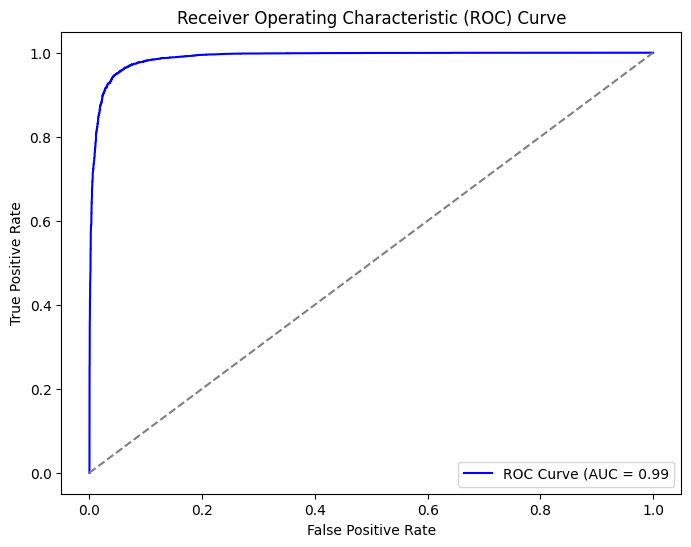

ROC-AUC Score: 0.9892


In [38]:
# Step 14: AUC-ROC for Model Discrimination
print("Plotting AUC-ROC Curve...")

y_prob = best_rf.predict_proba(X_test)[:, 1]  # Get probability scores for class 1
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(f"ROC-AUC Score: {auc_score:.4f}")

## Business Insights & Recommendations

In [39]:
# Step 15: Business Insights & Recommendations
print("Extracting Business Insights & Recommendations...")

# Identify Top Churn Indicators
top_features = feature_importance.head(10)  # Top 10 important features
print("Top Churn Indicators:\n", top_features)

# Recommendations
recommendations = {
    "Retention Strategies": "Offer discounts and exclusive plans for high-value customers likely to churn.",
    "Early Intervention": "Monitor declining recharge amounts and proactively reach out to at-risk customers.",
    "Marketing Focus": "Target customers with reduced data usage in personalized campaigns."
}

# Display recommendations
for key, value in recommendations.items():
    print(f"\n{key}:\n{value}")

Extracting Business Insights & Recommendations...
Top Churn Indicators:
                 Feature  Importance
15        roam_og_mou_8    0.065727
12        roam_ic_mou_8    0.064475
96     total_rech_amt_8    0.060744
99       max_rech_amt_8    0.059307
81       total_ic_mou_8    0.058170
3                arpu_8    0.042257
66         loc_ic_mou_8    0.034743
102  last_day_rch_amt_8    0.032937
30         loc_og_mou_8    0.024849
54       total_og_mou_8    0.023022

Retention Strategies:
Offer discounts and exclusive plans for high-value customers likely to churn.

Early Intervention:
Monitor declining recharge amounts and proactively reach out to at-risk customers.

Marketing Focus:
Target customers with reduced data usage in personalized campaigns.
